In [17]:
import numpy
import matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from scipy.optimize import curve_fit
from scipy.optimize import minimize
import scipy.fftpack as fft

from numpy import sin, pi
from numpy import random as rnd

%matplotlib inline
rnd.seed(201226)

1\. **Maximum wind speed prediction at the Sprogø station**

The exercise goal is to predict the maximum wind speed occurring every 50 years even if no measure exists for such a period. The available data are only measured over 21 years at the Sprogø meteorological station located in Denmark. 

The annual maxima are supposed to fit a normal probability density function. However such function is not going to be estimated because it gives a probability from a wind speed maxima. Finding the maximum wind speed occurring every 50 years requires the opposite approach, the result needs to be found from a defined probability. That is the quantile function role and the exercise goal will be to find it. In the current model, it is supposed that the maximum wind speed occurring every 50 years is defined as the upper 2% quantile.

By definition, the quantile function is the inverse of the cumulative distribution function. The latter describes the probability distribution of an annual maxima. In the exercise, the cumulative probability $p_i$ for a given year i is defined as $p_i = i/(N+1)$ with $N = 21$, the number of measured years. Thus it will be possible to calculate the cumulative probability of every measured wind speed maxima. From those experimental points, the scipy.interpolate module will be very useful for fitting the quantile function. Finally the 50 years maxima is going to be evaluated from the cumulative probability of the 2% quantile.

Practically, load the dataset:

```python
import numpy as np
max_speeds = np.load('max-speeds.npy')
years_nb = max_speeds.shape[0]
```

Compute then the cumulative probability $p_i$ (`cprob`) and sort the maximum speeds from the data. Use then the  UnivariateSpline from scipy.interpolate to define a quantile function and thus estimate the probabilities.

In the current model, the maximum wind speed occurring every 50 years is defined as the upper 2% quantile. As a result, the cumulative probability value will be:

```python
fifty_prob = 1. - 0.02
```

So the storm wind speed occurring every 50 years can be guessed as:

``` python
fifty_wind = quantile_func(fifty_prob)
```



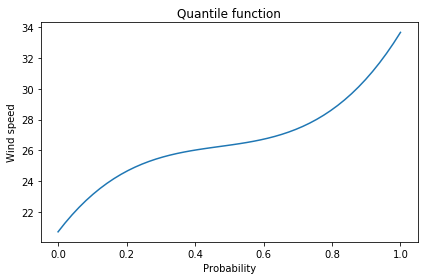

The maximum wind speed over 50 years is expected to be: 32.97989844019469


In [2]:
# load the dataset and sort
max_speeds = numpy.load("max-speeds.npy")
max_speeds.sort()

# compute the cumulative probability
years_nb = max_speeds.shape[0]
cprob = numpy.arange(1, years_nb+1) / (years_nb + 1)

# create the quantile function and plot it
quantile_func = UnivariateSpline(cprob, max_speeds)
x_plot = numpy.linspace(0, 1)
fig, ax = plt.subplots(1, figsize=(6,4))
ax.plot(x_plot, quantile_func(x_plot))
ax.set_xlabel("Probability")
ax.set_ylabel("Wind speed")
ax.set_title("Quantile function")
fig.tight_layout()
plt.show()

# get the wind speed relative to the 98% probability
fiftyyears_max = quantile_func(0.98)
print(f"The maximum wind speed over 50 years is expected to be: {fiftyyears_max}")

2\. **Curve fitting of temperature in Alaska** 

The temperature extremes in Alaska for each month, starting in January, are given by (in degrees Celcius):

max:  17,  19,  21,  28,  33,  38, 37,  37,  31,  23,  19,  18

min: -62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58

* Plot these temperature extremes.
* Define a function that can describe min and max temperatures. 
* Fit this function to the data with scipy.optimize.curve_fit().
* Plot the result. Is the fit reasonable? If not, why?
* Is the time offset for min and max temperatures the same within the fit accuracy?

Among the maximum temperatures, 38°C is the highest and 17°C is the lowest
Among the minimum temperatures, -9°C is the highest and -62°C is the lowest

The fitted function for maxima is: 10.58 * sin( 0.59 * (t - 3.07) ) + 27.95
The fitted function for minima is: 25.15 * sin( 0.60 * (t - 3.52) ) + -36.71


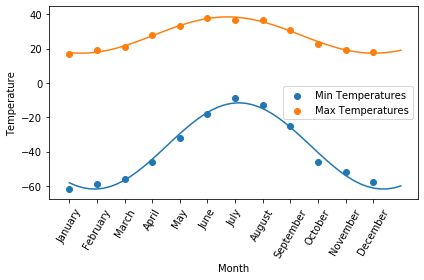

In [3]:
max_temp = numpy.array([17, 19, 21, 28, 33, 38, 37, 37, 31, 23, 19, 18])
min_temp = numpy.array([-62, -59, -56, -46, -32, -18, -9, -13, -25, -46, -52, -58])
months = numpy.array(["January", "February", "March", "April", "May", "June", "July", "August", "September", "October", "November", "December"])
time = numpy.arange(12)

# print the extremes for both maximum and minumum temperatures
print(f"Among the maximum temperatures, {max_temp.max()}°C is the highest and {max_temp.min()}°C is the lowest")
print(f"Among the minimum temperatures, {min_temp.max()}°C is the highest and {min_temp.min()}°C is the lowest")

# guess that the temperatures could follow a sine-cosine behaviour
def func(t, amp, freq, phase, offset):
    return amp * sin(freq * (t - phase)) + offset

# fit the guessed function to data
max_fit, _ = curve_fit(func, time, max_temp, [5, pi/12, 4, 20])
min_fit, _ = curve_fit(func, time, min_temp, [20, pi/12, 4, -40])
print()
print(f"The fitted function for maxima is: {max_fit[0]:.2f} * sin( {max_fit[1]:.2f} * (t - {max_fit[2]:.2f}) ) + {max_fit[3]:.2f}")
print(f"The fitted function for minima is: {min_fit[0]:.2f} * sin( {min_fit[1]:.2f} * (t - {min_fit[2]:.2f}) ) + {min_fit[3]:.2f}")

# plot data and fitted curve
fig, ax = plt.subplots(1)
xs = numpy.linspace(0, 12)
ax.plot(xs, func(xs, *min_fit))
ax.scatter(time, min_temp, label="Min Temperatures")
ax.plot(xs, func(xs, *max_fit))
ax.scatter(time, max_temp, label="Max Temperatures")
ax.set_ylabel("Temperature")
ax.set_xlabel("Month")
plt.xticks(time, months, rotation=60)
ax.legend()
fig.tight_layout()


The fit seems to be quite reasonable, especially for the maximum temperatures, the minima are worse distributed around the fitted line, but there's no evidence for the fitting model to be wrong.

The time offset is different between maximum and minimum temperatures, in fact the maxima tend to grow slightly before (half a month) with respect to the minima. This evidence could be explained by the fact that the maximum temperatures are due to the solar heating, while the minimum temperatures are due to the thermal inertia of the ground. When the Sun heats more, the day temperatures suddently rise, but it takes some more time to the ground to rise it's temperature during spring; on the other side, when the Sun gets colder, the day temperatures fall, but the ground takes some time to adjust. This process should produce a delay in the time offset of the two curves.

The frequency is almost the same and it makes sense since the period should be $12$ months.

The amplitude is very different between the two curves, it's much larger for the minima. This can be due to the fact that Alaska is in the Northern Hemisphere: the Sun is closer to Earth during winter and this balance the fewer daytime, implying that the maximum temperatures decrease less than the minimum ones during winter.

###### 3\. **2D minimization of a six-hump camelback function**

$$
f(x,y) = \left(4-2.1x^2+\frac{x^4}{3} \right) x^2 +xy + (4y^2 -4)y^2
$$

has multiple global and local minima. Find the global minima of this function.

Hints:

* Variables can be restricted to $-2 < x < 2$ and $-1 < y < 1$.
* Use numpy.meshgrid() and pyplot.pcolor() to find visually the regions.
* Use scipy.optimize.minimize(), optionally trying out several of its methods.

How many global minima are there, and what is the function value at those points? What happens for an initial guess of $(x, y) = (0, 0)$ ?


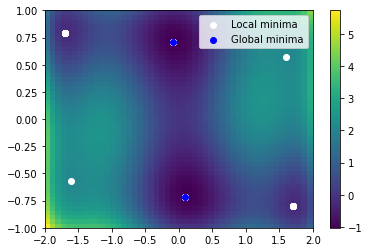

The global minima are 2 and the minima are in:
[[-0.08984  0.71266]
 [ 0.08984 -0.71266]]
The value in the global minima is: -1.0316284534898772

The minima found with initial guessing (0,0) are:
[[0. 0.]]
each counted times: [100]

The minimum obtained with initial guessing (0,0) using the Powell method is: [-0.08984  0.71266]


In [4]:
def f(x):
    return (4 - 2.1 * x[0]**2 + x[0]**4 / 3) * x[0]**2 + x[0] * x[1] + (4 * x[1]**2 - 4) * x[1]**2

# creating the grid to plot the 
xs = numpy.linspace(-2, 2)
ys = numpy.linspace(-1, 1)
grid = numpy.meshgrid(xs, ys)
Z = f(grid)

fig, ax = plt.subplots(1)
cbar = ax.pcolor(grid[0], grid[1], Z)
fig.colorbar(cbar)

# determining the initial guessings at random
rand_in_guessings = numpy.array([pair for pair in zip(rnd.uniform(-2, 2, 100), rnd.uniform(-1, 1, 100))])

# finding the local minima and plotting
loc_minima = numpy.array([minimize(f, initial).x for initial in rand_in_guessings])
ax.scatter(loc_minima[:,0], loc_minima[:,1], color='w', label="Local minima")

# determining the global minima and plotting
values = numpy.array([f(x) for x in loc_minima])
min_value = numpy.min(values)
glob_minima = loc_minima[ values == min_value ]
ax.scatter(glob_minima[:,0], glob_minima[:,1], color='b', label="Global minima")

ax.legend()
plt.show()

# counting and printing the global minima
glob_minima = numpy.around(glob_minima, decimals=5)
unique = numpy.unique(glob_minima, axis=0)
print(f"The global minima are {unique.shape[0]} and the minima are in:\n{unique}\nThe value in the global minima is: {min_value}")

# results for (0,0) as initial guessing
spec_in_guessing = numpy.zeros(2)
minima = numpy.array([minimize(f, spec_in_guessing).x for i in range(100)])
minima = numpy.around(minima, decimals=5)
unique, counts = numpy.unique(minima, axis=0, return_counts=True)
print(f"\nThe minima found with initial guessing (0,0) are:\n{unique}\neach counted times: {counts}")

# results for (0,0) as initial guessing with a specified method
minimum = minimize(f, spec_in_guessing, method='Powell').x
minimum = numpy.around(minimum, decimals=5)
print(f"\nThe minimum obtained with initial guessing (0,0) using the Powell method is: {minimum}")

We can first notice that the function $f(x,y)$ is even under a change $x\to-x$, $y\to-y$, so we can expect having minima in the form $(\pm x_\mathrm{min}, \pm y_\mathrm{min})$, that is effectively seen in the plot of the function.

Since the function is symmetric with respect to the z-axis the gradient in the origin is null.

We can evince from the colour plot that there are several local minima in the plotted region of the domain. We can find these minima by minimizing the function starting from randomly drawn initial values. If the initial values are dense enough, we should find all the local minima in this region. With $100$ initial values, we find all the minima, plotted in white on the colour plot.

Among these minima, we should identify the global one(s), that are the one(s) with lowes value of $f$. We find that the global minima are two and are in the expected form.

The minimization function uses, as default, a gradient-decendent algorithm to find the minimum of the funcion. Since the gradient is null in the origin, for $(0,0)$ as initial guessing the default algorithm can never move away from that point and finds minima in $(0,0)$ for $100/100$ attempts. We can avoid this problem using an algorithm that does not rely on the gradient, such as the Powell method. This method minimizes the function iteratively along two random directions, and so it is able to move away from the origin and find one true minimum. The minimum found of course depends on the minimization directions elected, that in these case are not specified.

4\. **FFT of a simple dataset**

Performe a periodicity analysis on the lynxs-hares population

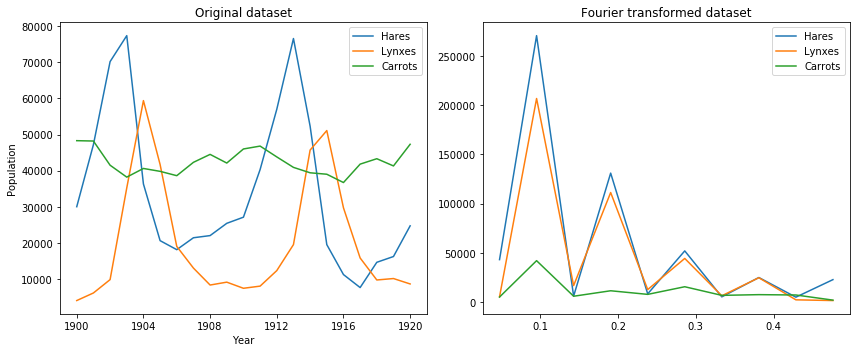

The hares population varies periodically every 10.5 years
The lynxes population varies periodically every 10.5 years
The carrots population varies periodically every 10.5 years


In [39]:
# loading the populations in a numpy array and plotting the original dataset
populations = numpy.loadtxt("populations.txt", delimiter='\t').astype(int)
fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].plot(populations[:,0], populations[:,1], label="Hares")
axs[0].plot(populations[:,0], populations[:,2], label="Lynxes")
axs[0].plot(populations[:,0], populations[:,3], label="Carrots")
axs[0].set_title("Original dataset")
axs[0].set_xlabel("Year")
axs[0].set_xticks(populations[::4, 0])
axs[0].set_ylabel("Population")
axs[0].legend()

# getting the modulus of the fft of the populations array
hares_fft = numpy.abs(fft.fft(populations[:,1]))
lynxes_fft = numpy.abs(fft.fft(populations[:,2]))
carrots_fft = numpy.abs(fft.fft(populations[:,3]))

# gettin the sample frequences and filtering for positive frequencies
sample_freq = fft.fftfreq(populations.shape[0])
mask = sample_freq > 0
sample_freq = sample_freq[mask]
hares_fft = hares_fft[mask]
lynxes_fft = lynxes_fft[mask]
carrots_fft = carrots_fft[mask]

# plotting the ffts
axs[1].plot(sample_freq, hares_fft, label="Hares")
axs[1].plot(sample_freq, lynxes_fft, label="Lynxes")
axs[1].plot(sample_freq, carrots_fft, label="Carrots")
axs[1].set_title("Fourier transformed dataset")
axs[1].legend()
fig.tight_layout()
plt.show()

# finding the peak frequency
print(f"The hares population varies periodically every {1 / sample_freq[hares_fft.argmax()]} years")
print(f"The lynxes population varies periodically every {1 / sample_freq[lynxes_fft.argmax()]} years")
print(f"The carrots population varies periodically every {1 / sample_freq[carrots_fft.argmax()]} years")

5\. **FFT of an image**

* Examine the provided image `moonlanding.png`, which is heavily contaminated with periodic noise. In this exercise, we aim to clean up the noise using the Fast Fourier Transform.
* Load the image using pylab.imread().
* Find and use the 2-D FFT function in scipy.fftpack, and plot the spectrum (Fourier transform of) the image. Do you have any trouble visualising the spectrum? If so, why?
* The spectrum consists of high and low frequency components. The noise is contained in the high-frequency part of the spectrum, so set some of those components to zero (use array slicing).
* Apply the inverse Fourier transform to see the resulting image.

Text(0.5, 1.0, 'Filtered image')

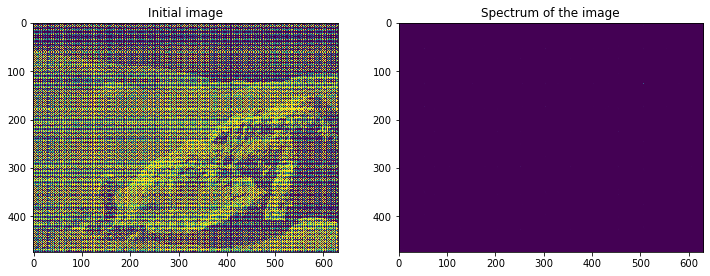

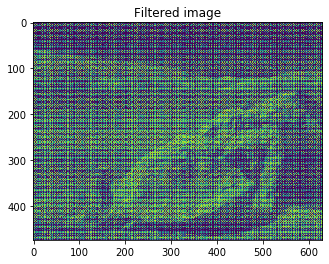

In [49]:
# loading the image as numpy array and plotting the initial results
image_array = plt.imread("moonlanding.png")
fig, axs = plt.subplots(1,2, figsize=(12,5))
axs[0].imshow(image_array)
axs[0].set_title("Initial image")

# getting the fourier transform of the image array and plotting the spectrum
image_fft = fft.fft2(image_array)
spectrum = numpy.abs(image_fft)
axs[1].imshow(spectrum)
axs[1].set_title("Spectrum of the image")

# filtering the highest frequences
image_fft[spectrum < numpy.mean(spectrum)] = 0
filtered_image = fft.ifft2(image_fft)
filtered_image = numpy.abs(filtered_image)
fig, ax = plt.subplots(1)
ax.imshow(filtered_image)
ax.set_title("Filtered image")